In [946]:
import pandas as pd
import numpy as np
from astropy.table import Table


import seaborn as sns

from scipy.optimize import curve_fit
from gal_data import gal_data
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
from astropy.modeling.models import Sersic1D
import findHalfLight

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

In [947]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['figure.facecolor'] = 'white'


In [948]:
ls

README.md                        mmres_placeholder_w1_fuv.csv
SersicFitsOfficial.ipynb         mmres_placeholder_w1_w2_fuv.csv
SersicFitsTest.ipynb             plots/
code/                            radprofilepkls/
data/


In [3]:
df = pd.read_pickle('radprofilepkls/W1_radprofiles.pkl')

In [4]:
mmres = pd.read_csv('data/mmres_allotherstuff.csv')

In [5]:
mmres.head()

,col1,col2,PGC,OBJNAME,R25_DEG,LOGMASS,DIST_MPC,GALTYPE_COURSE,re_des,re,...,nummasked,R25_arcsec,IDE,Com,Tmag,q,PosAng,n,Re,ratio_Salo
0,ESO011-005,15.6,67162,ESO011-005,0.013026,9.412712,41.70,LT,13.503322365031199,13.503322,...,98.0,46.894431,ESO011-005,NaN,14.52,0.231,43.46,1.329,18.61,0.587911
1,ESO012-010,45.1,72957,ESO012-010,0.009350,9.230704,32.40,LT,All NaN,NaN,...,NaN,33.660550,ESO012-010,NaN,13.31,0.493,156.97,1.592,56.38,NaN
2,ESO012-014,47.8,181,ESO012-014,0.012555,8.699477,32.40,LT,Bad Decomp,NaN,...,NaN,45.198209,ESO012-014,NaN,14.67,0.411,23.92,0.884,47.35,NaN
3,ESO013-016,26.3,5764,ESO013-016,0.017857,9.505092,24.55,LT,35.17570467128016,35.175705,...,947.0,64.286716,ESO013-016,NaN,12.75,0.508,168.64,1.314,38.85,0.332227
4,ESO015-001,28.6,13695,ESO015-001,0.011503,8.643700,22.70,LT,Bad Decomp,NaN,...,NaN,41.411527,ESO015-001,NaN,14.39,0.357,110.22,1.131,34.34,NaN


In [6]:
df.head()

,r_arcsec,I,Norm_I,gal
0,2.501307,0.303378,0.009883,PGC56796
1,5.620195,0.263937,0.018481,PGC56796
2,7.025627,0.257195,0.026859,PGC56796
3,7.510656,0.229316,0.034329,PGC56796
4,8.007439,0.255596,0.042655,PGC56796


In [7]:
from gal_data import gal_data
temp = gal_data(['PGC'+str(i) for i in mmres.PGC])['PGC','INCL_DEG','MORPH','T'].to_pandas()

In [8]:
mmres = mmres.merge(temp,on='PGC')

In [627]:
indexes = (np.logical_and(mmres.LOGMASS>10,mmres['T']>3)).index 

In [651]:
mmres.loc[mmres.PGC==1440]


,col1,col2,PGC,OBJNAME,R25_DEG,LOGMASS,DIST_MPC,GALTYPE_COURSE,re_des,re,...,Re,ratio_Salo,INCL_DEG,MORPH,T,Re_sersic,mm15_ratio,chisqs,Re_sersic_fuv,band_ratio
27,ESO150-005,46.3,1440,ESO150-005,0.01958,8.560298,13.7,LT,48.3960848126226,48.396085,...,64.79,0.768749,57.369999,b'SABd',7.7,84.279743,0.549361,23.96972,145.968419,0.577383


In [717]:
i=indexes[10488]
pgc = mmres.PGC[i]
r25 = mmres.R25_DEG[i]
rp = dffuv[dffuv['gal']=='PGC'+str(pgc)]
rp.r_arcsec/=3600.
mask = rp.r_arcsec<2*r25
rp = rp[mask]


275

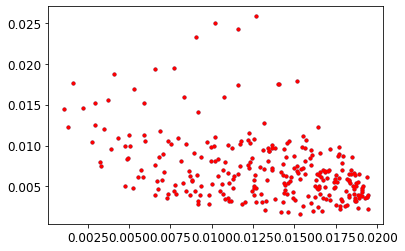

In [664]:
plt.figure()
plt.plot(rp.r_arcsec,rp.I,'.')
mask = rp.r_arcsec*3600<80
ind = np.where(rp.r_arcsec*3600<80)[0][-1]
plt.plot(rp.r_arcsec[mask],rp.I[mask],'r.')
ind

In [665]:
ind

275

291.6547992899334 2
12.605045103412209 3
Model: Sersic1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude              r_eff          n 
    -------------------- -------------------- ---
    0.009936883981247056 0.029798938513425324 4.0 107.27617864833117


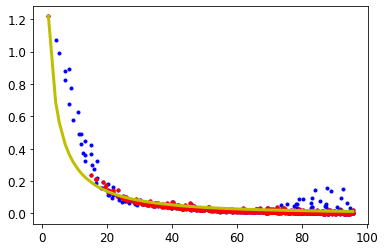

In [754]:
from astropy.modeling.models import Sersic2D
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from astropy.modeling import models, fitting

nrange = np.arange(3,14,1)
ind = np.where(rp.r_arcsec<.3*r25)[0][-1]

sersic = models.Sersic1D(bounds = {'n':(0,14)})
outlier_fit = fitting.FittingWithOutlierRemoval(fitting.LevMarLSQFitter(),sigma_clip, niter=2, sigma=3.0)
fitted_model,filtered_data = outlier_fit(sersic,rp.r_arcsec,rp.I,weights=(1./rp.r_arcsec))
filtered_data[:ind]=False
fit = fitting.LevMarLSQFitter()
fitted_model = fit(sersic,rp.r_arcsec[~filtered_data],rp.I[~filtered_data],weights=(1./rp.r_arcsec[~filtered_data]))


chisq = chisquare(fitted_model(rp.r_arcsec), f_exp=rp.I).statistic
print(chisq,n)
if chisq>100:
    for n in nrange:
        sersic = models.Sersic1D(bounds = {'n':(n,n+1)})
        outlier_fit = fitting.FittingWithOutlierRemoval(fitting.LevMarLSQFitter(),sigma_clip, niter=2, sigma=3.0)
        fitted_model,filtered_data = outlier_fit(sersic,rp.r_arcsec,rp.I,weights=(1./rp.r_arcsec))
        c = chisquare(fitted_model(rp.r_arcsec), f_exp=rp.I).statistic
        if c<chisq:
            chisq = c
            print(chisq,n)

        else:
            break
plt.figure()
plt.plot(rp.r_arcsec*3600,rp.I,'b.')
plt.plot(rp.r_arcsec[~filtered_data]*3600,rp.I[~filtered_data],'r.')
#plt.plot(rp.r_arcsec[:ind]*3600,rp.I[:ind],'g.')

plt.plot(rp.r_arcsec*3600,fitted_model(rp.r_arcsec),'y-',lw=3)
print(fitted_model, fitted_model.r_eff*3600)

In [720]:
np.nanmedian(rp.I[rp.r_arcsec>1.5*r25])

0.0001657418524119

In [728]:
from scipy.stats import chisquare
np.isclose(0.0001657418524119,0.,atol=1e-3)

True

In [729]:
np.isclose(np.nanmedian(rp.I[rp.r_arcsec>1.5*r25]),0,atol=1e-3)

True

In [786]:
0.1*rp.I

0       0.622752
1       0.471851
2       0.535044
3       0.522668
4       0.451736
          ...   
1539    0.001302
1540    0.000620
1541    0.000373
1542    0.000820
1543    0.001437
Name: I, Length: 1544, dtype: float64

In [787]:
rp.I[-400:] = 0.62

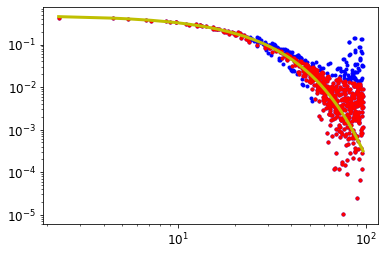


2919
0.7770606829252585 24.188954106448406
1.118 24.27
20.1
38.900001525878906



In [818]:
hls = []
for i in [12]:
    pgc = mmres.PGC[i]
    incl = mmres.INCL_DEG[i]
    r25 = mmres.R25_DEG[i]
    rp = df[df['gal']=='PGC'+str(pgc)]
    rp.r_arcsec/=3600. 
    mask = rp.r_arcsec<r25*2
    #rp.I/=rp.I.max()
    rp = rp[mask]
    nrange = np.arange(1,14,1)

   # if np.isclose(np.nanmedian(rp.I[rp.r_arcsec>1.5*r25]),0,atol=1e-3):
    #    pass
    #else:
     #   rp.I-=np.nanmedian(rp.I[rp.r_arcsec>1.5*r25])
   # try:
    ind = np.where(rp.r_arcsec<.5*r25)[0][-1]

    sersic = models.Sersic1D(bounds = {'n':(0,14)})
    outlier_fit = fitting.FittingWithOutlierRemoval(fitting.LevMarLSQFitter(),sigma_clip, niter=4, sigma=2.5)
    fitted_model,filtered_data = outlier_fit(sersic,rp.r_arcsec,rp.I)#,weights=0.1*rp.I)
    filtered_data[:ind]=False

    fit = fitting.LevMarLSQFitter()
    fitted_model = fit(sersic,rp.r_arcsec[~filtered_data],rp.I[~filtered_data])#,weights=(0.1*rp.I[~filtered_data]))
 
    plt.figure()
    plt.plot(rp.r_arcsec*3600,rp.I,'b.')
    plt.plot(rp.r_arcsec[~filtered_data]*3600,rp.I[~filtered_data],'r.')
    #plt.plot(rp.r_arcsec[:ind]*3600,rp.I[:ind],'g.')
    plt.plot(rp.r_arcsec*3600,fitted_model(rp.r_arcsec),'y-',lw=3)

    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(ymin= np.nanmin(rp.I[~filtered_data]))

    plt.show()
    plt.close()

    print("")
    print(pgc)
    print(fitted_model.n.value,fitted_model.r_eff.value*3600.)
    print(mmres.n[i],mmres.Re[i])
    print(mmres.col2[i])
    print(incl)
    print("")
    
   # except:
    #    print("")
     #   print('No fit!')
      #  print(pgc)
       # print("")

In [ ]:
"""
    chisq = chisquare(fitted_model(rp.r_arcsec[~filtered_data]), f_exp=rp.I[~filtered_data]).statistic
    print(chisq)

    if np.logical_or(chisq>40,chisq<0):
        for n in nrange:
            sersic = models.Sersic1D(bounds = {'n':(n,n+1)})
            outlier_fit = fitting.FittingWithOutlierRemoval(fitting.LevMarLSQFitter(),sigma_clip, niter=3, sigma=3.0)
            fitted_model,filtered_data_chisq = outlier_fit(sersic,rp.r_arcsec,rp.I,weights=(0.1*rp.I[~filtered_data]))
            c = chisquare(fitted_model(rp.r_arcsec[~filtered_data]), f_exp=rp.I[~filtered_data]).statistic
            while True:
                if np.logical_and(c<chisq,chisq>0):
                    chisq = c
                    print(chisq,n)
                elif np.logical_and(c>chisq,chisq<0):
                    chisq = c
                    print(chisq,n)
                else:
                    continue
                break
"""  

In [ ]:
mmres[mmres.PGC==17567]

In [640]:
from importlib import reload
reload(findHalfLight)

<module 'findHalfLight' from '/Users/kessler.363/Thesis/Concentrationz0mgs/code/findHalfLight.py'>

In [360]:
mmres
pgcs=['PGC'+str(i) for i in mmres.PGC]

In [361]:
pgcs,halflights,amps,ns,datamasks,nummasked,chisqs = findHalfLight.findHalfLightSersicdf(pgcs,mmres,df)

2346
2345
2344
2343
2342
2341
2340
2339
2338
2337
2336
2335
2334
2333
2332
2331
2330
2329
2328
2327
2326
2325
2324
2323
2322
2321
2320
2319
2318
2317
2316
2315
2314
2313
2312
2311
2310
2309
2308
2307
2306
2305
2304
2303
2302
2301
2300
2299
2298
2297
2296
2295
2294
2293
2292
2291
2290
2289
2288
2287
2286
2285
2284
2283
2282
2281
2280
2279
2278
2277
2276
2275
2274
2273
2272
2271
2270
2269
2268
2267
2266
2265
2264
2263
2262
2261
2260
2259
2258
2257
2256
2255
2254
2253
2252
2251
2250
2249
2248
2247
2246
2245
2244
2243
2242
2241
2240
2239
2238
2237
2236
2235
2234
2233
2232
2231
2230
2229
2228
2227
2226
2225
2224
2223
2222
2221
2220
2219
2218
2217
2216
2215
2214
2213
2212
2211
2210
2209
2208
2207
2206
2205
2204
2203
2202
2201
2200
2199
2198
2197
2196
2195
2194
2193
2192
2191
2190
2189
2188
2187
2186
2185
2184
2183
2182
2181
2180
2179
2178
2177
2176
2175
2174
2173
2172
2171
2170
2169
2168
2167
2166
2165
2164
2163
2162
2161
2160
2159
2158
2157
2156
2155
2154
2153
2152
2151
2150
2149
2148
2147


634
633
632
631
630
629
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385


In [373]:
hls = [np.nan if h=='fit fail' else float(h) for h in halflights]

In [374]:
hls

[15.32679129997521,
 nan,
 nan,
 34.656372084808616,
 nan,
 26.564515765031647,
 38.99173731547099,
 44.42758111697537,
 32.03470001506229,
 51.110036266680225,
 nan,
 29.036653217575395,
 22.997388089171512,
 nan,
 18.66128888832139,
 60.88469265479359,
 nan,
 26.490770826783564,
 nan,
 1454.642513490594,
 121.25689181400348,
 28.573323828378538,
 42.63469078375227,
 nan,
 nan,
 nan,
 nan,
 84.27974250831846,
 nan,
 26.38438837649021,
 36.57116373403622,
 nan,
 54.02978399676795,
 nan,
 52.202109413189106,
 30.504075212693934,
 48.18018991788169,
 34.07199015429459,
 nan,
 27.516666197658672,
 16.222719452242774,
 nan,
 nan,
 nan,
 103.99451134055585,
 51.7792943071641,
 18.945487852958394,
 nan,
 nan,
 nan,
 nan,
 41.296490146002796,
 18.28726438494622,
 nan,
 26.99010603764876,
 nan,
 23.922138866840864,
 nan,
 nan,
 34.14040596799758,
 57.75290047033894,
 nan,
 36.286771128914616,
 nan,
 39.15040209711478,
 nan,
 nan,
 nan,
 48.794421316648645,
 26.012561973390763,
 42.121819265058

In [375]:
mmres.ratio_Salo= mmres.Re/hls

In [428]:
mmres['Re_sersic'] = hls
mmres['mm15_ratio'] = mmres.col2/test.Re_sersic
mmres['chisqs'] = chisqs

In [429]:
(mmres[mmres.INCL_DEG<=70].ratio_Salo).describe()

count    1015.000000
mean        1.354585
std         2.696505
min         0.000782
25%         0.783780
50%         0.972829
75%         1.234051
max        50.191319
Name: ratio_Salo, dtype: float64

In [430]:
mask =np.logical_and(mmres.INCL_DEG<=70,mmres.ratio_Salo<100)
test = mmres[mask]

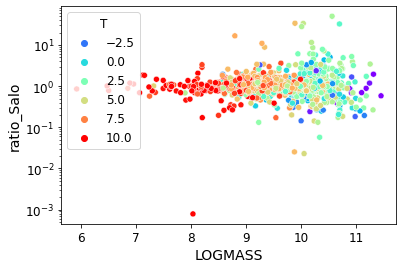

In [433]:

s=sns.scatterplot(y='ratio_Salo',x='LOGMASS',data=test,hue='T',palette='rainbow')
s.set_yscale('log')

In [434]:
import pandasFunctions

In [563]:
std_bin = pandasFunctions.rollingstdXY(test,'LOGMASS',np.arange(6,12.5,.5))
med_bin = pandasFunctions.rollingmedainXY(test,'LOGMASS',np.arange(6,12.5,.5))


(0.5144867238950458, 2)

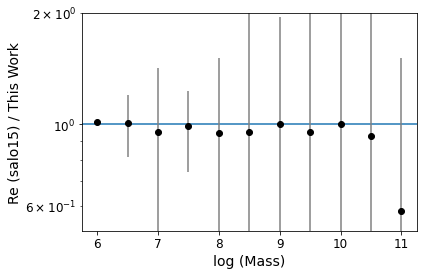

In [752]:
plt.plot(np.arange(6,12.5,.5)[:-1],med_bin.ratio_Salo,'ko')
plt.errorbar(np.arange(6,12.5,.5)[:-1],med_bin.ratio_Salo,yerr=std_bin.ratio_Salo,fmt='none',color='gray')
plt.axhline(y=1,zorder=0)
plt.ylabel('Re (salo15) / This Work')
plt.xlabel('log (Mass)')
plt.yscale('log')
plt.ylim(-2,2)

In [437]:
test['mm15_ratio'].describe()

count    1004.000000
mean        0.777911
std         0.286542
min         0.000854
25%         0.619658
50%         0.790481
75%         0.928334
max         2.438564
Name: mm15_ratio, dtype: float64

In [438]:
std_bin = pandasFunctions.rollingstdXY(test,'LOGMASS',np.arange(6,12.5,.5))
med_bin = pandasFunctions.rollingmedainXY(test,'LOGMASS',np.arange(6,12.5,.5))

Text(0.5, 0, 'log (Mass)')

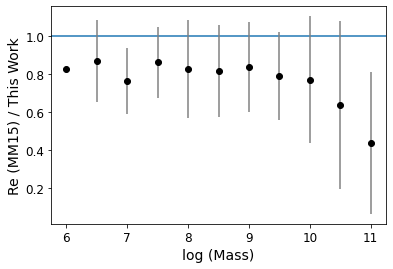

In [439]:
plt.plot(np.arange(6,12.5,.5)[:-1],med_bin.mm15_ratio,'ko')
plt.errorbar(np.arange(6,12.5,.5)[:-1],med_bin.mm15_ratio,yerr=std_bin.mm15_ratio,fmt='none',color='gray')
plt.axhline(y=1,zorder=0)
plt.ylabel('Re (MM15) / This Work')
plt.xlabel('log (Mass)')

In [738]:
indexes = test[test.ratio_Salo>2].index
indexes

Int64Index([   5,    6,   32,   75,  212,  220,  353,  396,  465,  493,  501,
             514,  529,  543,  563,  565,  576,  582,  597,  623,  624,  640,
             671,  676,  678,  698,  705,  775,  828,  835,  837,  897,  901,
             908,  934,  981,  996, 1010, 1044, 1091, 1140, 1207, 1224, 1233,
            1281, 1297, 1317, 1333, 1346, 1370, 1371, 1392, 1400, 1414, 1417,
            1433, 1437, 1458, 1483, 1493, 1498, 1499, 1510, 1515, 1532, 1552,
            1567, 1580, 1582, 1591, 1593, 1614, 1627, 1644, 1656, 1658, 1669,
            1736, 1803, 1917, 2002, 2087, 2107, 2110, 2190, 2195],
           dtype='int64')

In [735]:
test.ratio_Salo.describe()

count    1015.000000
mean        1.354585
std         2.696505
min         0.000782
25%         0.783780
50%         0.972829
75%         1.234051
max        50.191319
Name: ratio_Salo, dtype: float64

(9.221699280555715, 10000.0)

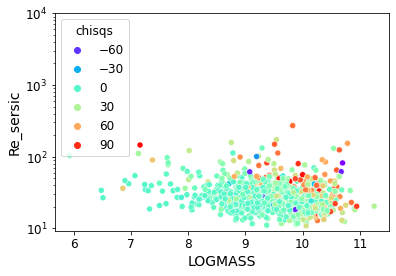

In [463]:
mask = np.logical_and(test.chisqs>-100,test.chisqs<100)
test2 = test[mask]
s=sns.scatterplot(y='Re_sersic',x='LOGMASS',data=test2,hue='chisqs',palette='rainbow')
s.set_yscale('log')
plt.ylim(0,1e4)

In [751]:
med_bin[['ratio_Salo','mm15_ratio']]

,ratio_Salo,mm15_ratio
LOGMASS,,
"(6.0, 6.5]",1.014481,0.822791
"(6.5, 7.0]",1.008506,0.867866
"(7.0, 7.5]",0.955960,0.760227
"(7.5, 8.0]",0.988434,0.860319
"(8.0, 8.5]",0.945751,0.825672
"(8.5, 9.0]",0.954724,0.814319
"(9.0, 9.5]",1.002546,0.836035
"(9.5, 10.0]",0.954506,0.788934
"(10.0, 10.5]",1.001169,0.769189


In [750]:
std_bin[['ratio_Salo','mm15_ratio']]

,ratio_Salo,mm15_ratio
LOGMASS,,
"(6.0, 6.5]",NaN,NaN
"(6.5, 7.0]",0.193807,0.213108
"(7.0, 7.5]",0.461537,0.173045
"(7.5, 8.0]",0.244851,0.185593
"(8.0, 8.5]",0.569587,0.258196
"(8.5, 9.0]",1.363511,0.240683
"(9.0, 9.5]",0.947637,0.236096
"(9.5, 10.0]",2.244374,0.228830
"(10.0, 10.5]",3.129235,0.332687


In [423]:
chisqs = [np.nan if c=='fit fail' else float(c) for c in chisqs]

In [442]:
test.chisqs.describe()

count     1015.000000
mean       -86.537548
std       3548.599595
min     -87858.382700
25%          3.772134
50%         12.192741
75%         45.966144
max      18076.321902
Name: chisqs, dtype: float64

In [464]:
dffuv = pd.read_pickle('radprofilepkls/FUV_radprofiles.pkl')
pgcs=['PGC'+str(i) for i in mmres.PGC]

In [465]:
pgcs,halflights,amps,ns,datamasks,nummasked,chisqs = findHalfLight.findHalfLightSersicdf(pgcs,mmres,dffuv)

2346
2345
2344
2343
2342
2341
2340
2339
2338
2337
2336
2335
2334
2333
2332
2331
2330
2329
2328
2327
2326
2325
2324
2323
2322
2321
2320
2319
2318
2317
2316
2315
2314
2313
2312
2311
2310
2309
2308
2307
2306
2305
2304
2303
2302
2301
2300
2299
2298
2297
2296
2295
2294
2293
2292
2291
2290
2289
2288
2287
2286
2285
2284
2283
2282
2281
2280
2279
2278
2277
2276
2275
2274
2273
2272
2271
2270
2269
2268
2267
2266
2265
2264
2263
2262
2261
2260
2259
2258
2257
2256
2255
2254
2253
2252
2251
2250
2249
2248
2247
2246
2245
2244
2243
2242
2241
2240
2239
2238
2237
2236
2235
2234
2233
2232
2231
2230
2229
2228
2227
2226
2225
2224
2223
2222
2221
2220
2219
2218
2217
2216
2215
2214
2213
2212
2211
2210
2209
2208
2207
2206
2205
2204
2203
2202
2201
2200
2199
2198
2197
2196
2195
2194
2193
2192
2191
2190
2189
2188
2187
2186
2185
2184
2183
2182
2181
2180
2179
2178
2177
2176
2175
2174
2173
2172
2171
2170
2169
2168
2167
2166
2165
2164
2163
2162
2161
2160
2159
2158
2157
2156
2155
2154
2153
2152
2151
2150
2149
2148
2147


633
632
631
630
629
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384


In [467]:
hlsfuv = [np.nan if h=='fit fail' else float(h) for h in halflights]

In [469]:
mmres['Re_sersic_fuv'] = hlsfuv

In [520]:
mask =np.logical_and(mmres.INCL_DEG<=70,mmres.ratio_Salo<100)
test = mmres[mask]

In [517]:
(mmres.Re_sersic/mmres.Re_sersic_fuv).median()

0.8557025039608334

In [518]:
mmres['band_ratio']=(mmres.Re_sersic/mmres.Re_sersic_fuv)

In [521]:
std_bin = pandasFunctions.rollingstdXY(test,'LOGMASS',np.arange(6,12.5,.5))
med_bin = pandasFunctions.rollingmedainXY(test,'LOGMASS',np.arange(6,12.5,.5))

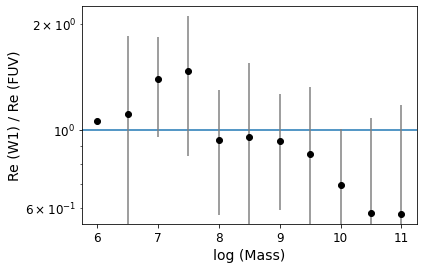

In [753]:
plt.plot(np.arange(6,12.5,.5)[:-1],med_bin.band_ratio,'ko')
plt.errorbar(np.arange(6,12.5,.5)[:-1],med_bin.band_ratio,yerr=std_bin.band_ratio,fmt='none',color='gray')
plt.axhline(y=1,zorder=0)
plt.ylabel('Re (W1) / Re (FUV)')
plt.xlabel('log (Mass)')
plt.yscale('log')

Text(0, 0.5, 'Re (W1) - Re (FUV)')

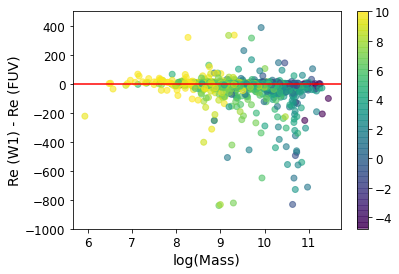

In [549]:
#plt.scatter(mmres.LOGMASS,mmres.Re_sersic_fuv)
plt.scatter(mmres.LOGMASS,mmres.Re_sersic-mmres.Re_sersic_fuv,c=mmres['T'],alpha=0.6)
plt.axhline(y=0,color='r')
#plt.yscale('log')
plt.colorbar()
plt.ylim(-1000,5e2)
plt.xlabel('log(Mass)')
plt.ylabel('Re (W1) - Re (FUV)')

Text(0, 0.5, 'Re (W1) / Re (FUV)')

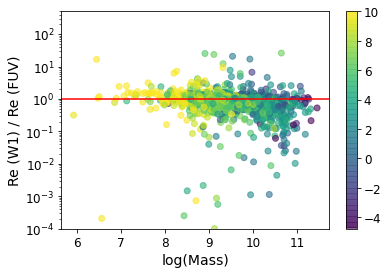

In [550]:
#plt.scatter(mmres.LOGMASS,mmres.Re_sersic_fuv)
plt.scatter(mmres.LOGMASS,mmres.Re_sersic/mmres.Re_sersic_fuv,c=mmres['T'],alpha=0.6)
plt.axhline(y=1,color='r')
plt.yscale('log')
plt.colorbar()
plt.ylim(1e-4,5e2)
plt.xlabel('log(Mass)')
plt.ylabel('Re (W1) / Re (FUV)')

In [551]:
med_bin

,col2,PGC,R25_DEG,LOGMASS,DIST_MPC,re,ratio,ratio2,nummasked,R25_arcsec,...,n,Re,ratio_Salo,INCL_DEG,T,Re_sersic,mm15_ratio,chisqs,Re_sersic_fuv,band_ratio
LOGMASS,,,,,,,,,,,,,,,,,,,,,
"(6.0, 6.5]",27.90,50961.0,0.008766,6.478428,2.290000,NaN,NaN,0.885346,214.0,31.558855,...,0.4620,34.400,1.014481,58.740002,9.90,33.908957,0.822791,0.791590,32.050240,1.057994
"(6.5, 7.0]",28.90,41034.0,0.012768,6.873525,4.130000,17.430107,1.276694,0.455019,350.0,45.965274,...,1.0070,39.625,1.008506,66.680000,9.85,38.957680,0.867866,2.207973,33.411577,1.112998
"(7.0, 7.5]",37.60,38692.0,0.013422,7.298196,4.970000,36.640211,0.975501,0.627713,548.0,48.319368,...,0.8510,37.570,0.955960,60.119999,9.90,40.859437,0.760227,2.384241,29.338494,1.399989
"(7.5, 8.0]",29.80,40832.5,0.012171,7.769422,7.305000,36.521567,0.819981,0.662548,427.0,43.815569,...,0.8795,30.825,0.988434,53.334999,9.90,35.464360,0.860319,2.882870,24.228831,1.475738
"(8.0, 8.5]",25.10,38416.0,0.011345,8.273017,13.594322,23.883408,0.938367,1.178423,364.5,40.843448,...,1.0615,29.810,0.945751,57.345001,9.70,28.777540,0.825672,4.017670,28.680512,0.934941
"(8.5, 9.0]",24.00,36063.5,0.011228,8.815798,19.700000,23.773925,0.884712,0.650053,396.5,40.422348,...,1.3355,29.795,0.954724,54.225000,7.90,29.961019,0.814319,4.141757,28.781803,0.953906
"(9.0, 9.5]",22.95,38749.5,0.013269,9.242633,21.100000,25.136456,0.912869,0.835067,532.5,47.767403,...,1.4040,28.225,1.002546,53.580000,6.15,26.855454,0.836035,6.734735,30.883925,0.928472
"(9.5, 10.0]",22.00,41117.0,0.015500,9.755866,25.700000,21.781397,0.950706,0.799445,739.0,55.798376,...,1.5080,27.140,0.954506,53.375000,5.00,26.731028,0.788934,13.254178,31.914043,0.853894
"(10.0, 10.5]",24.70,39224.0,0.021273,10.222990,22.900000,21.735087,1.062716,1.103358,1490.0,76.581030,...,2.0950,37.070,1.001169,54.750000,3.60,29.185636,0.769189,39.376905,40.838016,0.694603


In [552]:
mmres.R25_DEG.describe()

count    2346.000000
mean        0.020887
std         0.017464
min         0.005493
25%         0.011697
50%         0.015879
75%         0.023923
max         0.248782
Name: R25_DEG, dtype: float64

In [553]:
std_bin = pandasFunctions.rollingstdXY(test,'R25_DEG',np.arange(0,.25,.05))
med_bin = pandasFunctions.rollingmedainXY(test,'R25_DEG',np.arange(0,.25,.05))

In [554]:
std_bin

,col2,PGC,R25_DEG,LOGMASS,DIST_MPC,re,ratio,ratio2,nummasked,R25_arcsec,...,n,Re,ratio_Salo,INCL_DEG,T,Re_sersic,mm15_ratio,chisqs,Re_sersic_fuv,band_ratio
R25_DEG,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0.05]",14.128395,49848.263180,0.008615,0.765193,10.834897,17.027984,6.409978,1.051926,1402.323217,31.013405,...,2.451862,114.110137,2.543995,11.342832,3.243133,4436.521034,0.266788,592.179684,5.916183e+10,0.455813
"(0.05, 0.1]",26.497927,17498.772556,0.015597,0.758812,5.610592,41.244374,0.736290,3.728733,8383.411971,56.150291,...,3.416593,378.806671,5.056673,15.179920,3.543549,725.161454,0.536372,13545.826765,1.337479e+02,0.477803
"(0.1, 0.15]",60.070650,13017.604644,0.016153,0.887442,5.337023,139.755199,0.503922,258.751828,15921.283057,58.152047,...,5.736987,89.748785,1.161783,21.227258,2.061472,342.575620,0.596932,21617.715456,1.108853e+02,1.364414
"(0.15, 0.2]",50.065257,23440.377478,0.019084,0.730815,2.491164,12.929039,0.182817,0.984585,65258.150007,68.703233,...,1.259361,40.153658,0.261449,21.299062,2.362908,308.913151,0.305298,24813.015205,7.616476e+02,0.097255


In [555]:
med_bin

,col2,PGC,R25_DEG,LOGMASS,DIST_MPC,re,ratio,ratio2,nummasked,R25_arcsec,...,n,Re,ratio_Salo,INCL_DEG,T,Re_sersic,mm15_ratio,chisqs,Re_sersic_fuv,band_ratio
R25_DEG,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0.05]",23.75,39143,0.015164,9.568047,22.42849,23.350651,0.948993,0.830002,687.0,54.591024,...,1.523,30.190,0.978789,54.139999,5.2,28.455449,0.799598,11.368976,32.881415,0.851967
"(0.05, 0.1]",67.50,37617,0.061634,10.568930,14.20000,49.341344,1.347034,2.091428,14537.0,221.881557,...,2.919,100.620,0.875808,54.000000,4.0,121.417225,0.587292,431.708297,125.010081,0.592327
"(0.1, 0.15]",145.20,39511,0.113847,10.537372,6.26500,109.023388,1.091355,2.162473,40395.0,409.849021,...,3.163,265.845,1.125288,57.820000,4.5,223.560703,0.515608,2352.672448,136.404462,0.472696
"(0.15, 0.2]",240.50,28630,0.180227,10.385830,3.65000,262.903708,0.844807,0.691608,93317.0,648.815578,...,1.312,220.990,0.595201,48.509998,5.9,464.464583,0.555909,-5234.964172,1139.432351,0.175408


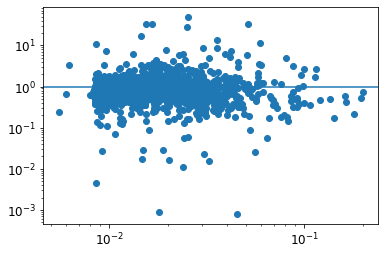

In [559]:
plt.scatter(mmres.R25_DEG,mmres.ratio_Salo)
plt.yscale('log')
plt.xscale('log')
plt.axhline(y=1)

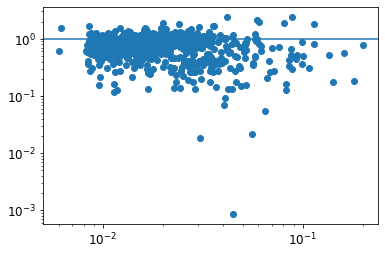

In [560]:
plt.scatter(mmres.R25_DEG,mmres.mm15_ratio)
plt.yscale('log')
plt.xscale('log')
plt.axhline(y=1)

In [858]:
from astropy.table import Table
di = Table.read('data/delivery_index_gauss15.fits').to_pandas()

In [859]:
di.PGC_NAME = di.PGC_NAME.str.decode('utf-8')
di.PGC_NAME = [int(i.strip().split('PGC')[-1]) for i in di.PGC_NAME]

In [909]:
masknew = ['Full Sample' if i==False else 'Salo15' for i in mask]
di['Data']=masknew

In [910]:
di.Samples

0        Full Sample
1             Salo15
2        Full Sample
3        Full Sample
4        Full Sample
            ...     
15743    Full Sample
15744    Full Sample
15745    Full Sample
15746    Full Sample
15747    Full Sample
Name: Samples, Length: 15748, dtype: object

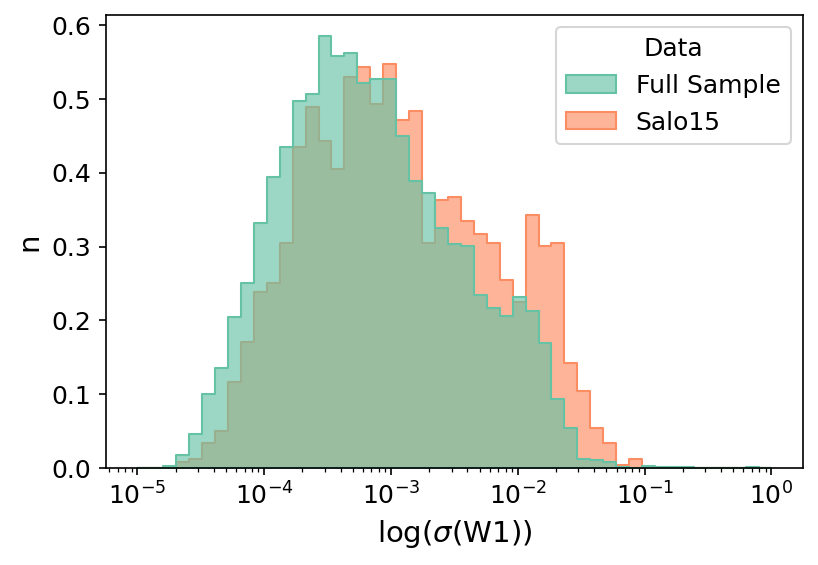

In [949]:
plt.figure(dpi=150)
sns.histplot(data=di,x='STD_FLUX_WISE1',log_scale=True,bins=np.linspace(-5,0,50),hue='Data',
             element="step",stat="density",common_norm=False,multiple='layer',palette='Set2',alpha=0.65)
plt.xlabel(r'log($\sigma$(W1))')
plt.ylabel('n')
#plt.savefig('plots/STD_SamplevSalo.png',bbox_inches='tight')

Text(0, 0.5, 'n')

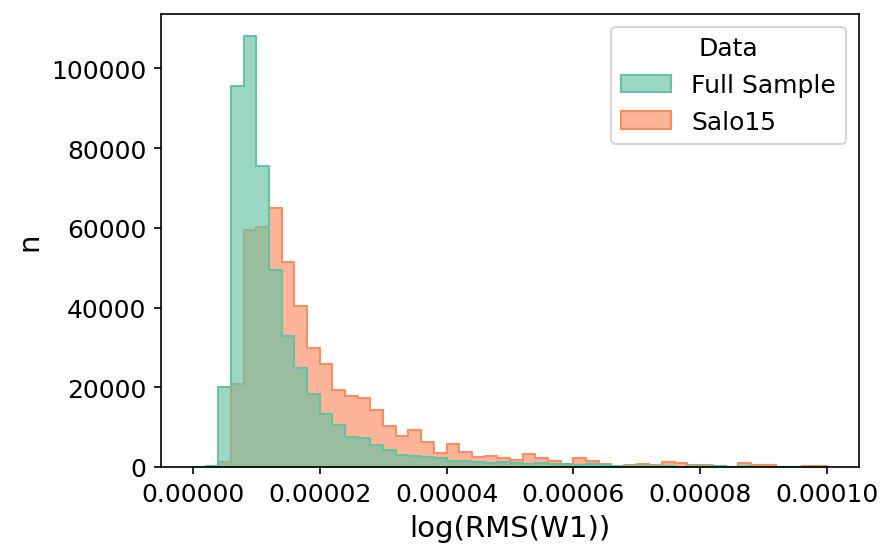

In [964]:
plt.figure(dpi=150)
sns.histplot(data=di,x='RMS_FLUX_WISE1',log_scale=False,bins=50,binrange=(0,1e-4),hue='Data',
             element="step",stat="density",common_norm=False,multiple='layer',palette='Set2',alpha=0.65)
plt.xlabel(r'log(RMS(W1))')
plt.ylabel('n')
#plt.savefig('plots/RMS_SamplevSalo.png',bbox_inches='tight')

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,  2.,
         3.,  8., 12., 18., 27., 37., 51., 50., 50., 73., 89., 69., 70.,
        71., 73., 97., 82., 93., 96., 79., 79., 80., 63., 66., 61., 59.,
        55., 50., 50., 43., 55., 53., 57., 35., 34., 35., 27., 32., 24.,
        17., 23., 18., 15., 14., 14., 10., 20.,  9.,  6., 12.,  8.,  4.,
         7.,  6.,  8.,  3.,  3.,  7.,  0.,  2.]),
 array([-6.        , -5.97979798, -5.95959596, -5.93939394, -5.91919192,
        -5.8989899 , -5.87878788, -5.85858586, -5.83838384, -5.81818182,
        -5.7979798 , -5.77777778, -5.75757576, -5.73737374, -5.71717172,
        -5.6969697 , -5.67676768, -5.65656566, -5.63636364, -5.61616162,
        -5.5959596 , -5.57575758, -5.55555556, -5.53535354, -5.51515152,
        -5.49494949, -5.47474747, -5.45454545, -5.43434343, -5.41414141,
 

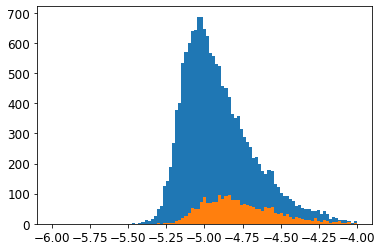

In [873]:
plt.hist(np.log10(di.RMS_FLUX_WISE1),bins=np.linspace(-6,-4,100))
plt.hist(np.log10(di.RMS_FLUX_WISE1[mask]),bins=np.linspace(-6,-4,100))

In [846]:
mmres.PGC

0       67162
1       72957
2         181
3        5764
4       13695
        ...  
2341    72882
2342    72900
2343    72977
2344    72983
2345       38
Name: PGC, Length: 2346, dtype: int64

In [869]:
mask = di.PGC.isin(mmres.PGC)